In [ ]:
!pip install openpyxl
!pip install kneed
!pip install -U sentence-transformers

In [1]:
import re 
import pickle
import sys

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.cluster import KMeans, MiniBatchKMeans
from kneed import KneeLocator

from sklearn.metrics.cluster import v_measure_score, homogeneity_score, completeness_score
from sklearn.preprocessing import OneHotEncoder


In [3]:
features_df = pd.read_csv("calculated_files/subcat_features.csv")

## Clustering

In [4]:
ohe_features_df = features_df.copy().drop(["Purpose", "AttributeValue"], axis=1)
ohe_features_df = ohe_features_df.set_index('Konzernartikelnummer')

In [5]:
'''Removing the NAN values in the features_df, caused by the left merge with the Konzernartikelnummer (KAN), 
leaving empty rows from the subcategories (layers).'''

ohe_features_df.dropna(subset=['layer_1', 'layer_2', 'layer_3', 'layer_4'], inplace=True) 
ohe_features_df.isnull().sum()
# before dropping: 1973873 rows, after: 1932183 rows -> 41,690 rows dropped

AttributeKey    0
layer_1         0
layer_2         0
layer_3         0
layer_4         0
dtype: int64

the kernel crashes when including the Attribute values

In [6]:
'''using scikit learn's one hot encoder, with drop first'''
drop_enc = OneHotEncoder(drop='first').fit(ohe_features_df)
transformed_ohe_features = drop_enc.transform(ohe_features_df).toarray()

In [7]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

v_measures_df_ohe_key = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_ohe_key = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_ohe_key = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

# A list holds the SSE values for each k
sse = []
v_measures = []
homogeneity_measures = []
completeness_measures = []

# for k in range(1, 150, 5):
for k in range(1, 226, 5):
    print(k)
    kmeans = MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(transformed_ohe_features)
    sse.append(kmeans.inertia_)

    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(ohe_features_df['layer_1'], kmeans.labels_))
    v_measures.append(v_measure_score(ohe_features_df['layer_2'], kmeans.labels_))
    v_measures.append(v_measure_score(ohe_features_df['layer_3'], kmeans.labels_))
    v_measures.append(v_measure_score(ohe_features_df['layer_4'], kmeans.labels_))
    
    homogeneity_measures.append(homogeneity_score(ohe_features_df['layer_1'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(ohe_features_df['layer_2'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(ohe_features_df['layer_3'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(ohe_features_df['layer_4'], kmeans.labels_))

    completeness_measures.append(completeness_score(ohe_features_df['layer_1'], kmeans.labels_))
    completeness_measures.append(completeness_score(ohe_features_df['layer_2'], kmeans.labels_))
    completeness_measures.append(completeness_score(ohe_features_df['layer_3'], kmeans.labels_))
    completeness_measures.append(completeness_score(ohe_features_df['layer_4'], kmeans.labels_))

    v_measures_df_ohe_key.loc[len(v_measures_df_ohe_key)] = v_measures
    homogeneity_measures_df_ohe_key.loc[len(homogeneity_measures_df_ohe_key)] = homogeneity_measures
    completness_measures_df_ohe_key.loc[len(completness_measures_df_ohe_key)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []
    

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221


In [7]:
# v_measures_df_ohe_key.to_csv('calculated_files/evaluation_metric_dfs/v_measures_df_ohe_key.csv', index=False)
# homogeneity_measures_df_ohe_key.to_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_ohe_key.csv', index=False)
# completness_measures_df_ohe_key.to_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_ohe_key.csv', index=False)
# np.save('calculated_files/sse/sse_ohe.npy', sse)

v_measures_df_ohe_key = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_df_ohe_key.csv')
homogeneity_measures_df_ohe_key= pd.read_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_ohe_key.csv')
completness_measures_df_ohe_key = pd.read_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_ohe_key.csv')
sse = np.load('calculated_files/sse/sse_ohe.npy', allow_pickle=True)

### Plotting

Elbow

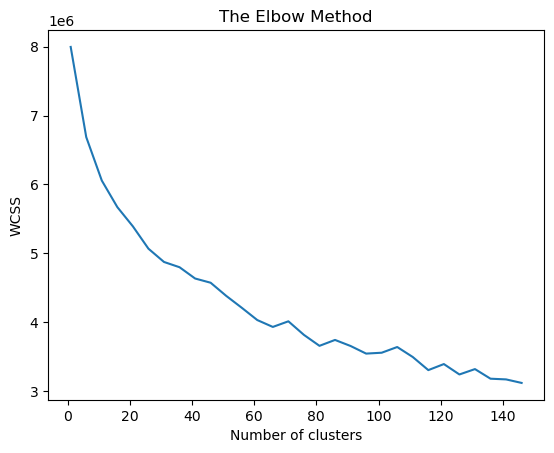

In [16]:
plt.plot(range(1, 150, 5), sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### V-measure

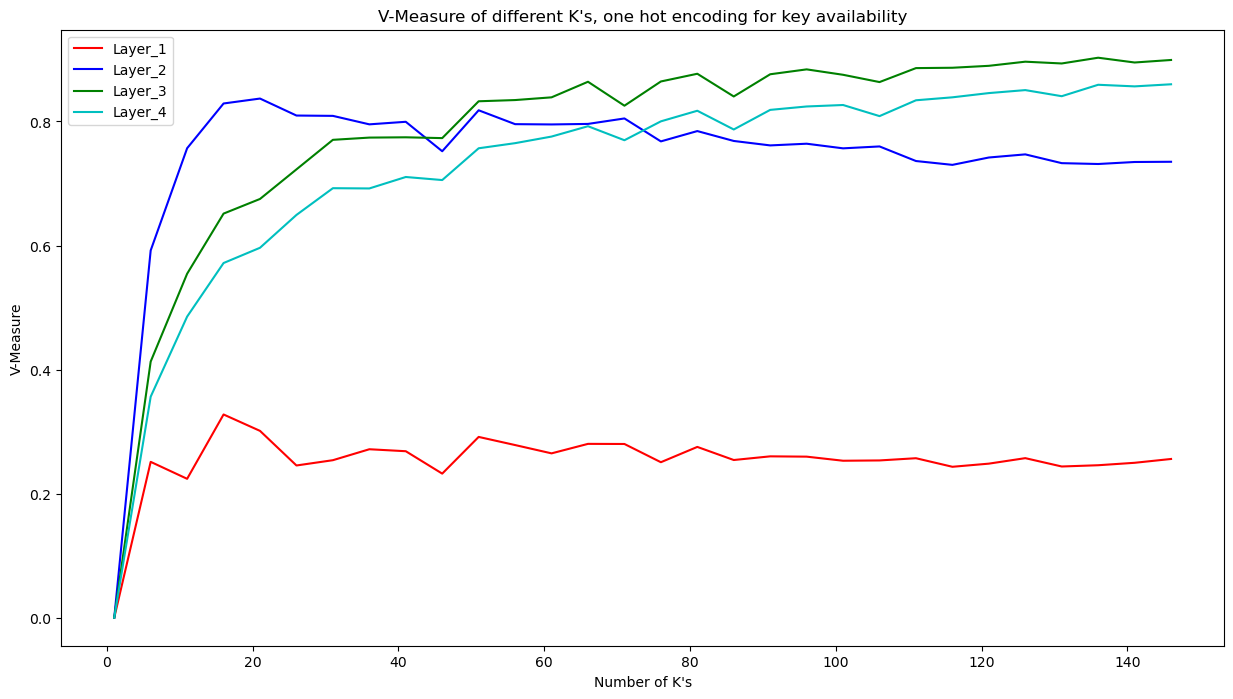

In [4]:
plot, ax = plt.subplots()
# plt.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_1'], 'r', range(1, 150, 5), v_measures_df_ohe_key['layer_2'], 'b', range(1, 150, 5), v_measures_df_ohe_key['layer_3'], 'g', range(1, 150, 5), v_measures_df_ohe_key['layer_4'], 'c')

ax.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_1'], 'r', label='Layer_1')
ax.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_2'], 'b', label='Layer_2')
ax.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_3'], 'g', label='Layer_3')
ax.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_4'], 'c', label='Layer_4')
plot.set_size_inches(15, 8)

ax.legend()
ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, one hot encoding for key availability")

plt.show()

#### Homogeneity

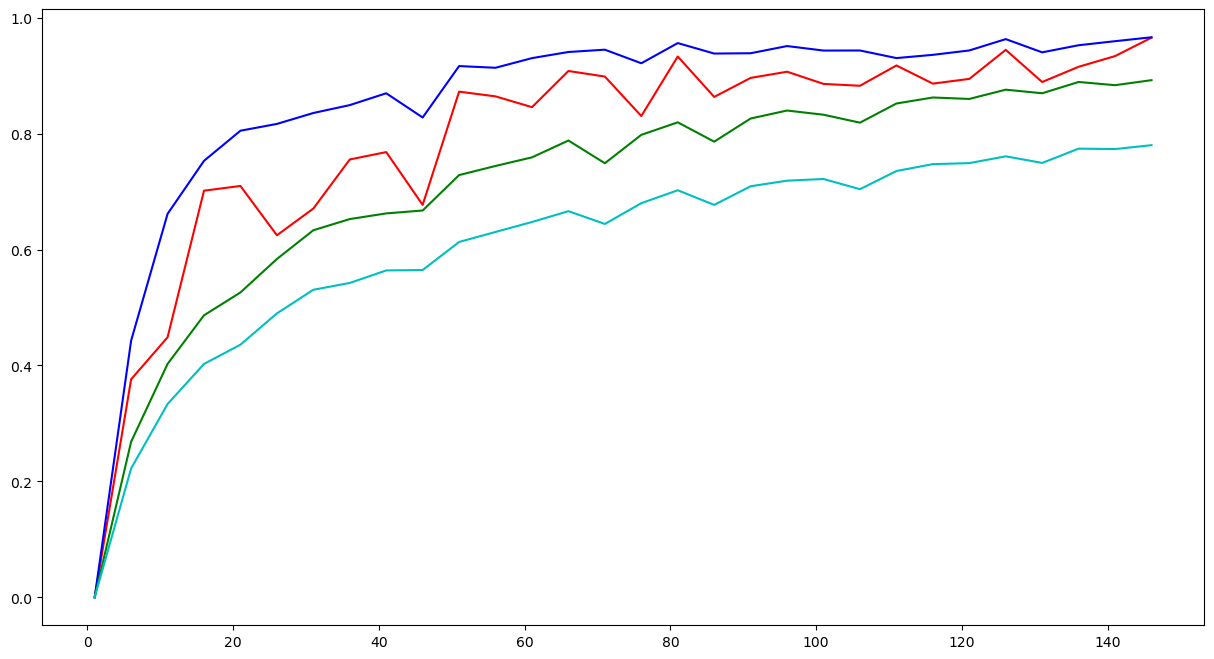

In [5]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), homogeneity_measures_df_ohe_key['layer_1'], 'r', range(1, 150, 5), homogeneity_measures_df_ohe_key['layer_2'], 'b', range(1, 150, 5), homogeneity_measures_df_ohe_key['layer_3'], 'g', range(1, 150, 5), homogeneity_measures_df_ohe_key['layer_4'], 'c')
plot.set_size_inches(15, 8)
plt.show()

#### Completeness

The completeness score of clustering indicates whether all the data points that are members of a given class belong to the same cluster. It is a floating point number between 0 and 1. A completeness score of 1 indicates that all samples with the same true label are assigned to the same cluster.

https://www.thesecuritybuddy.com/unsupervised-machine-learning/how-to-measure-clustering-performance-using-completeness-score/#:~:text=The%20completeness%20score%20of%20clustering,assigned%20to%20the%20same%20cluster.


The percentage of non-missing values in a dataset. A higher completeness ratio indicates a more complete dataset, and a lower one indicates a more incomplete dataset.

https://www.linkedin.com/advice/0/how-do-you-check-data-completeness-before-starting#:~:text=One%20way%20to%20measure%20data,indicates%20a%20more%20incomplete%20dataset.

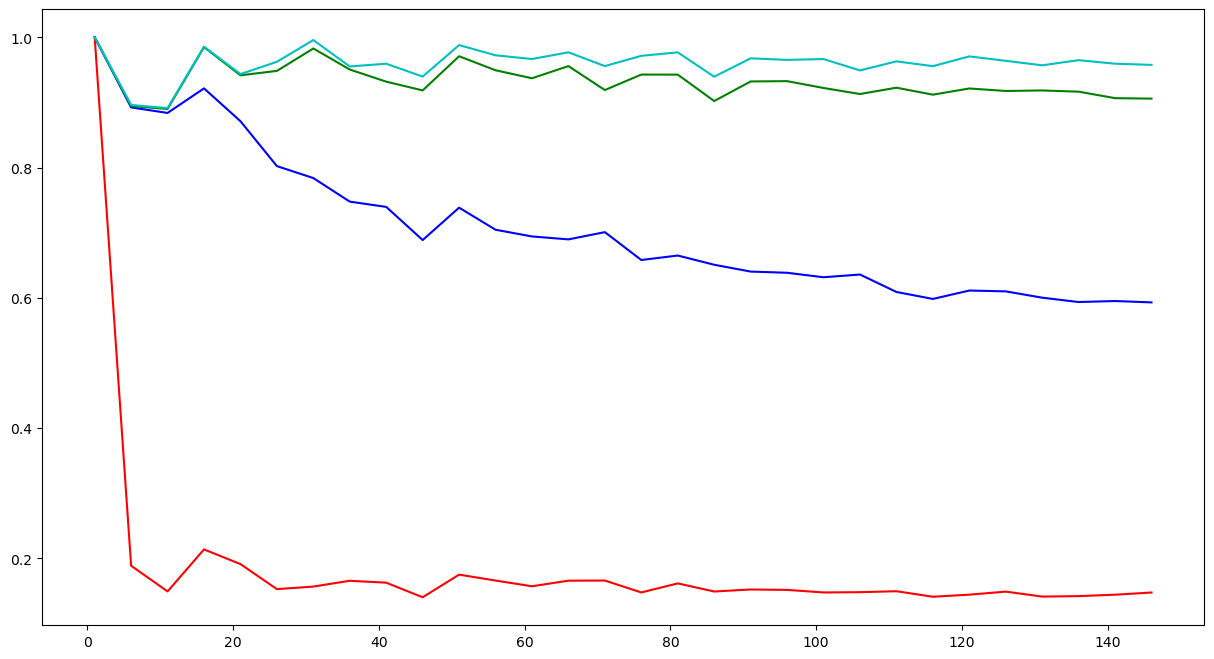

In [6]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), completness_measures_df_ohe_key['layer_1'], 'r', range(1, 150, 5), completness_measures_df_ohe_key['layer_2'], 'b', range(1, 150, 5), completness_measures_df_ohe_key['layer_3'], 'g', range(1, 150, 5), completness_measures_df_ohe_key['layer_4'], 'c')
plot.set_size_inches(15, 8)

plt.show()

##### Cluster with 226 clusters (over-cluster the second layer)
was aiming for 440 clusters but the server crashed

###### V-measure

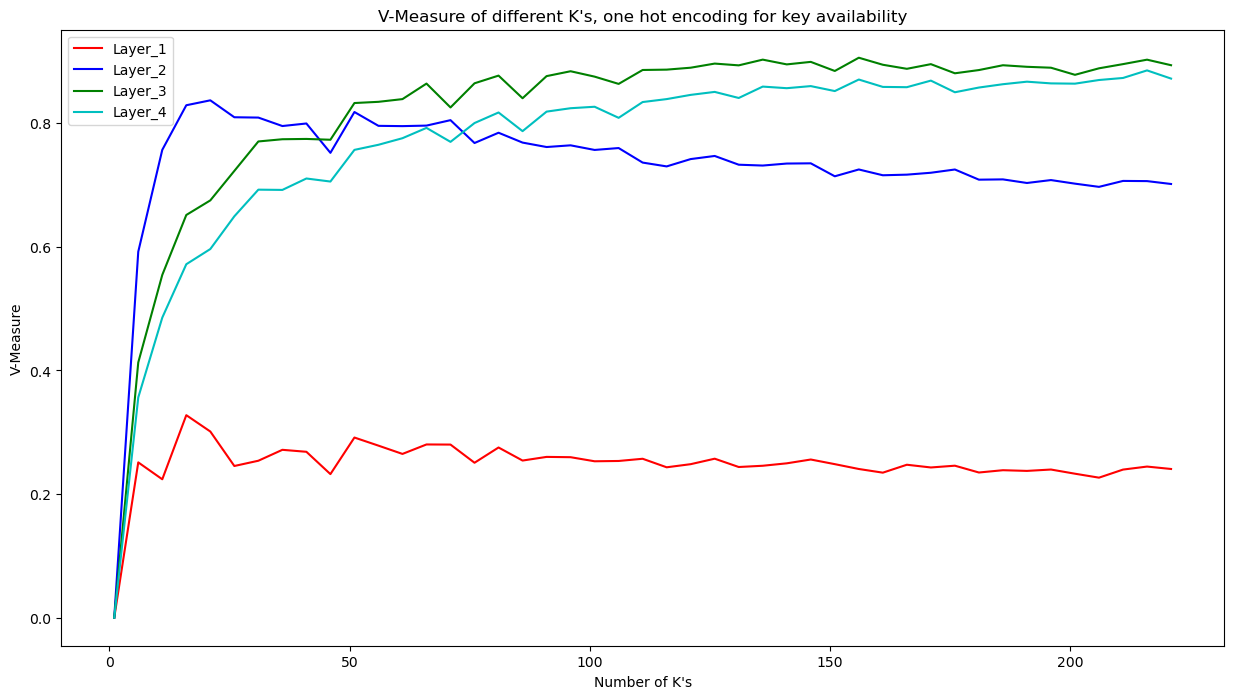

In [8]:
plot, ax = plt.subplots()
# plt.plot(range(1, 150, 5), v_measures_df_ohe_key['layer_1'], 'r', range(1, 150, 5), v_measures_df_ohe_key['layer_2'], 'b', range(1, 150, 5), v_measures_df_ohe_key['layer_3'], 'g', range(1, 150, 5), v_measures_df_ohe_key['layer_4'], 'c')

ax.plot(range(1, 226, 5), v_measures_df_ohe_key['layer_1'], 'r', label='Layer_1')
ax.plot(range(1, 226, 5), v_measures_df_ohe_key['layer_2'], 'b', label='Layer_2')
ax.plot(range(1, 226, 5), v_measures_df_ohe_key['layer_3'], 'g', label='Layer_3')
ax.plot(range(1, 226, 5), v_measures_df_ohe_key['layer_4'], 'c', label='Layer_4')
plot.set_size_inches(15, 8)

ax.legend()
ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, one hot encoding for key availability")

plt.show()

###### Homogeneity

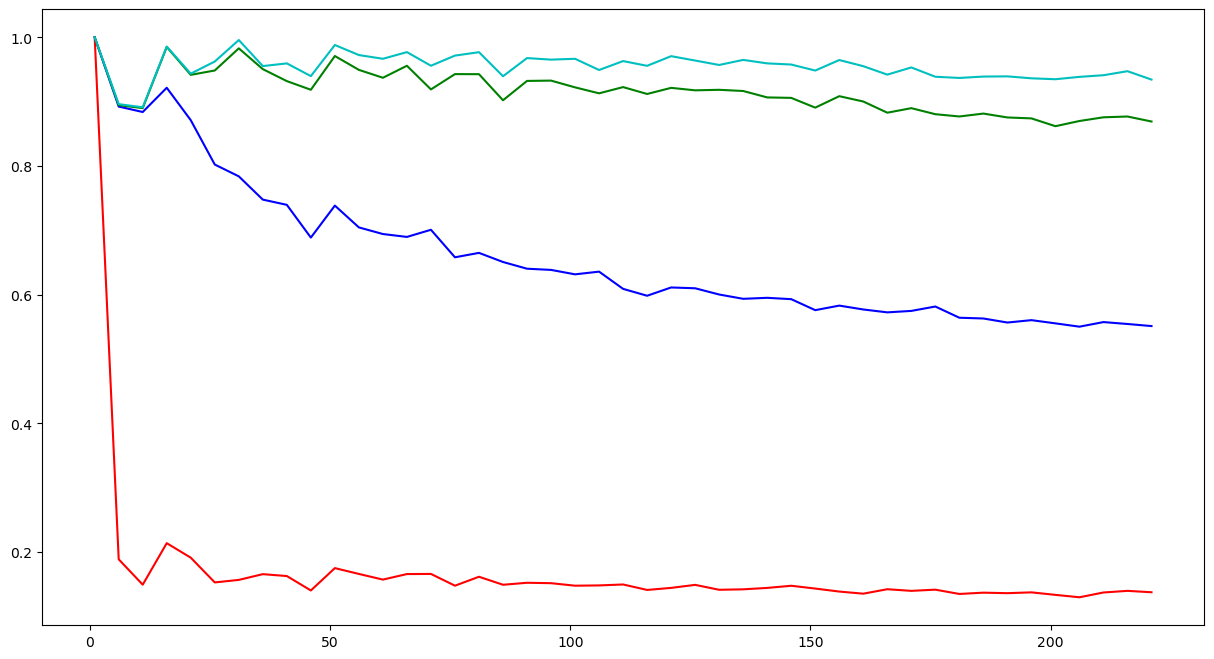

In [9]:
plot, ax = plt.subplots()
plt.plot(range(1, 226, 5), completness_measures_df_ohe_key['layer_1'], 'r',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_2'], 'b',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_3'], 'g',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_4'], 'c')
plot.set_size_inches(15, 8)

plt.show()

###### Completeness

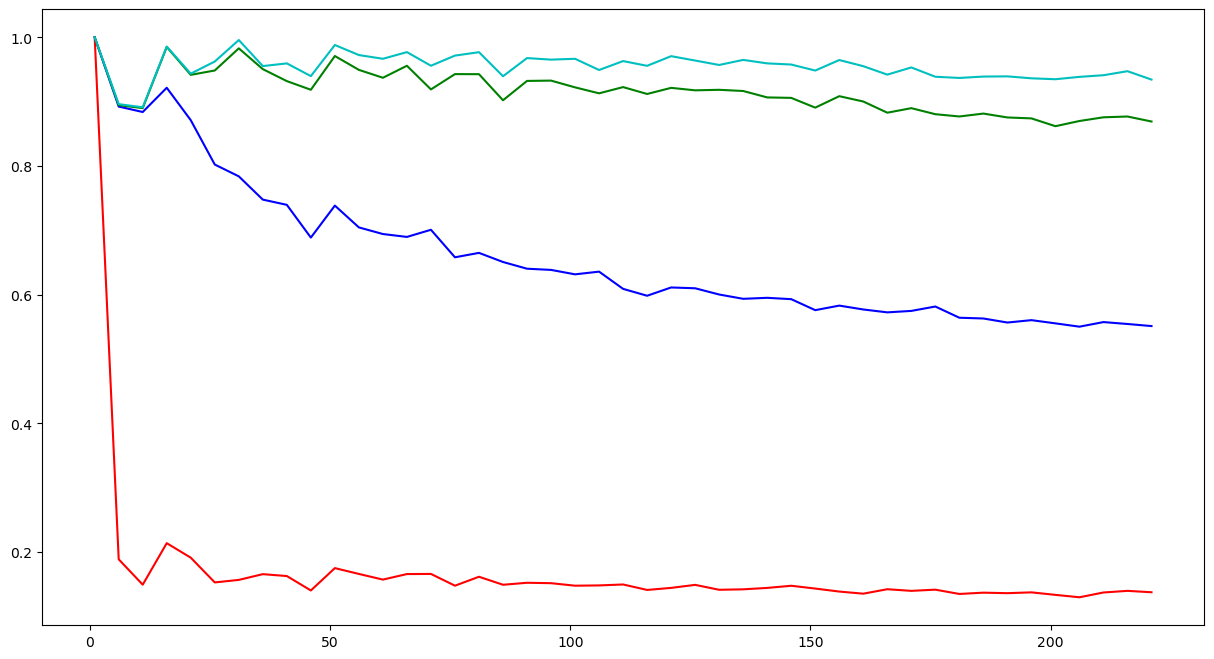

In [10]:
plot, ax = plt.subplots()
plt.plot(range(1, 226, 5), completness_measures_df_ohe_key['layer_1'], 'r',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_2'], 'b',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_3'], 'g',
         range(1, 226, 5), completness_measures_df_ohe_key['layer_4'], 'c')
plot.set_size_inches(15, 8)

plt.show()

# HDBSCAN

In [ ]:
pip install hdbscan
# from sklearn.cluster import HDBSCAN
import hdbscan
# from sklearn.cluster import HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(transformed_ohe_features)

In [ ]:


from sklearn.cluster import DBSCAN, HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=8, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(transformed_ohe_features)

np.save('calculated_files/hdbscan/ohe_feature_availability.npy', cluster_labels)
# cluster_labels = np.load('calculated_files/hdbscan/lblcluster_MPnet.npy', allow_pickle=True) 

: 